In [1]:
# Basic Packages
import numpy as np
import h5py
import logging
import os
import shutil
import gc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress, pearsonr, spearmanr
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.stats as stats
import math
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
import pickle
import random
# Physics-related Packages
from astropy.cosmology import Planck15
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
import astropy.units as u
from scipy.optimize import root_scalar
from sklearn.inspection import permutation_importance

In [ ]:
# preparations for read box info from the url
import requests
import time

baseUrl = 'http://www.tng-project.org/api/'

def get(path, params=None, max_retries=5, backoff_factor=2):
    # make HTTP GET request to path
    headers = {"api-key":"API KEY"}

    attempt = 0
    while attempt < max_retries:
        try:
            r = requests.get(path, params=params, headers=headers)
            r.raise_for_status()

            if r.headers['content-type'] == 'application/json':
                return r.json()
            
            if 'content-disposition' in r.headers:
                filename = r.headers['content-disposition'].split("filename=")[1]
                with open(filename, 'wb') as f:
                    f.write(r.content)
                return filename
            return r  # fallback
        
        except Exception as e:
            attempt += 1
            wait = backoff_factor ** attempt
            print(f"[Retry {attempt}/{max_retries}] Request failed: {e}. Retrying in {wait}s...")
            time.sleep(wait)

    raise RuntimeError(f"Failed to GET {path} after {max_retries} retries.")

In [3]:
# Issue a request to the API root
r = get(baseUrl)

# Print out all the simulation names
names = [sim['name'] for sim in r['simulations']]
# Get the index of TNG300-1
i = names.index('TNG-Cluster')
# Get the info of simulation Illustris-3
sim = get( r['simulations'][i]['url'] )
sim.keys()

# get the snaps info this simulation
snaps = get(sim['snapshots'])

In [4]:
def find_redshift_from_lookback_time(tau_gyr):
    """
    Given a look back time, return the redshift
    """

    if tau_gyr >= Planck15.lookback_time(0.01).value:
        tau = tau_gyr * u.Gyr


        def f(z):
            return (Planck15.lookback_time(z) - tau).value  


        result = root_scalar(f, bracket=[0.01, 20], method='brentq')
        
        if result.converged:
            return result.root
        else:
            raise RuntimeError("Root finding failed for tau = {:.2f} Gyr".format(tau_gyr))
    
    else:
        return 0.


In [5]:
snap_numbers = np.zeros(len(snaps))
snap_redshifts = np.zeros(len(snaps))
for i, snap in enumerate(snaps):
    snap_numbers[i] = snap['number']
    snap_redshifts[i] = snap['redshift']

def find_nearest_snap(z):
    delta_z = np.abs(snap_redshifts - z)
    target_snap = snap_numbers[np.argmin(delta_z)]
    return int(target_snap)

In [6]:
def convert_feats_labels_to_training_set_snapcut_tv(feats_labels_dict, snap_cut, tau):
    feature_vectors = []
    label_scores = []
    label_scores_pre = []
    meta_info = []  

    for halo_id in feats_labels_dict:
        # print(halo_id)
        for snap in feats_labels_dict[halo_id]:
            if snap <= snap_cut:
                # print(halo_id,'*',snap)
                Redshift = snaps[snap]['redshift'] 
                h_at0 = Planck15.h
                scale = 1 / (h_at0 * (1 + Redshift))
                
                if f'label_score_all_tau{tau}' not in feats_labels_dict[halo_id][snap]:
                    print(f'label_scores_tau{tau} for halo {halo_id} and snap {snap}','vansish')
                    continue
                label = feats_labels_dict[halo_id][snap][f'label_score_all_tau{tau}']
                label_pre = feats_labels_dict[halo_id][snap][f'label_score_pre_tau{tau}']
                #print(snap)
                projections = feats_labels_dict[halo_id][snap]['features']
                
                for proj in projections:

                    feats = projections[proj]

                    # Convert dict values to a fixed-order feature vector
                    vec = [
                        (feats['mean_r_0'] - feats['mean_r_1']) * scale, #0
                        feats['mean_v_0'], #1
                        feats['mean_v_1'], #2
                        np.abs(feats['mean_v_0']-feats['mean_v_1']), #3
                        feats['std_r_0']* scale, #4
                        feats['std_r_1']* scale, #5
                        feats['std_v_0'], #6
                        feats['std_v_1'], #7
                        min(feats['n0'], feats['n1'])/max(feats['n0'], feats['n1']), #8
                        feats['bic_1'], #9
                        feats['bic_2'], #10
                        feats['bic_2'] - feats['bic_1'] - 6*np.log(feats['n0']+ feats['n1']), #11
                        feats['elongation_ratio'],  # 12
                        feats_labels_dict[halo_id][snap]['redshift'], #13
                        feats_labels_dict[halo_id][snap]['mass_ratio'], #14
                        feats['std_r'] * scale, #15
                        feats['std_v'], #16
                    ]
                    #print(feats['n0']+ feats['n1'])
                    feature_vectors.append(vec)
                    label_scores.append(label)
                    label_scores_pre.append(label_pre)
                    meta_info.append((halo_id, snap, proj))

    return np.array(feature_vectors), np.array(label_scores), np.array(label_scores_pre), meta_info

In [7]:
def get_feats_label(snapcut, tau):
    with open('/home/chuiyang/merger_trace/data/tng_cluster/tng_cluster_products/feats_labels_dict_tngcluster.pkl', 'rb') as f:
        feats_labels_dict = pickle.load(f)

    feature_vectors, label_scores, label_scores_pre, meta_info = convert_feats_labels_to_training_set_snapcut_tv(feats_labels_dict, snapcut, tau)

    return feature_vectors, label_scores, label_scores_pre, meta_info

In [8]:
def XGboost_singletau_premerger_allmerger(tau, state = 'pre_merger', random_state = 42):
    if state == 'pre_merger':
        snapcut  = 100
        feature_vectors, label_scores, label_scores_pre, meta_info = get_feats_label(snapcut, tau)
        label_score_usedfor = label_scores_pre

    elif state == 'all_merger':
        cut_z = find_redshift_from_lookback_time(tau)
        snapcut = find_nearest_snap(cut_z)
        feature_vectors, label_scores, label_scores_pre, meta_info = get_feats_label(snapcut, tau)
        label_score_usedfor = label_scores

    
    elif state == 'post_merger':
        cut_z = find_redshift_from_lookback_time(tau)
        snapcut = find_nearest_snap(cut_z)
        feature_vectors, label_scores, label_scores_pre, meta_info = get_feats_label(snapcut, tau)
        label_score_usedfor = label_scores-label_scores_pre
    
    else:
        print('Please choose the right version of label scores')
    
    mask = np.where((label_score_usedfor >= 0 )& (label_score_usedfor <=20))[0].astype(int)

    # grouping data
    # groups = [f"{hid}_{snap}" for (hid, snap, proj) in np.array(meta_info)[mask]]
    groups = [hid for (hid, snap, proj) in np.array(meta_info)[mask]]
    n_samples = len(feature_vectors[mask])
    assert len(label_score_usedfor[mask]) == n_samples == len(groups)

    # split training data and test data
    X = np.arange(len(groups))
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, label_score_usedfor[mask], groups=groups))

    X_train, X_test = feature_vectors[mask][train_idx], feature_vectors[mask][test_idx]
    y_train, y_test = label_score_usedfor[mask][train_idx], label_score_usedfor[mask][test_idx]
    group_train = np.array(groups)[train_idx]  # for GridSearchCV

    # set search grid for hyper parameters
    param_grid = {
    'learning_rate': [0.005,0.01,0.05, 0.1, 0.2],
    'max_depth': [1, 2, 4, 6, 8, 10],
    'n_estimators': [100, 200, 300, 500, 1000],
    }

    #initialize model and grid search
    model = XGBRegressor(random_state=random_state)
    cv_splitter = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=random_state)

    grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='r2',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1
    )

    grid.fit(X_train, y_train, groups=group_train)

    # predict using best model 

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Best Params: {grid.best_params_}")
    print(f"XGBoost MSE: {mse:.4f}")
    print(f"XGBoost R²: {r2:.4f}")

    # visualize data
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k', linewidths=0.3)
    plt.plot([0, 5], [0, 5], 'r--', label='Perfect Prediction')
    plt.xlabel('True Merger Score')
    plt.ylabel('Predicted Merger Score')
    plt.title('XGBoost: True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    y_train_pred = best_model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    print(f"Training R²: {r2_train:.4f}")
    print(f"Training MSE: {mse_train:.4f}")

    return (mse, r2, mse_train, r2_train, n_samples, y_test, y_pred, label_score_usedfor[mask],
            )

label_scores_tau0.1 for halo 476245 and snap 80 vansish
label_scores_tau0.1 for halo 1263653 and snap 89 vansish
label_scores_tau0.1 for halo 3556542 and snap 87 vansish
label_scores_tau0.1 for halo 8714627 and snap 74 vansish
label_scores_tau0.1 for halo 8714627 and snap 90 vansish
label_scores_tau0.1 for halo 10017312 and snap 92 vansish
label_scores_tau0.1 for halo 10612178 and snap 78 vansish
label_scores_tau0.1 for halo 11484512 and snap 76 vansish
label_scores_tau0.1 for halo 13792287 and snap 89 vansish
label_scores_tau0.1 for halo 15031462 and snap 91 vansish
label_scores_tau0.1 for halo 15620242 and snap 96 vansish
label_scores_tau0.1 for halo 16103108 and snap 94 vansish
label_scores_tau0.1 for halo 16276166 and snap 77 vansish
label_scores_tau0.1 for halo 16892124 and snap 98 vansish
label_scores_tau0.1 for halo 18057470 and snap 76 vansish
label_scores_tau0.1 for halo 18351627 and snap 92 vansish
label_scores_tau0.1 for halo 18969218 and snap 89 vansish
Fitting 3 folds for 

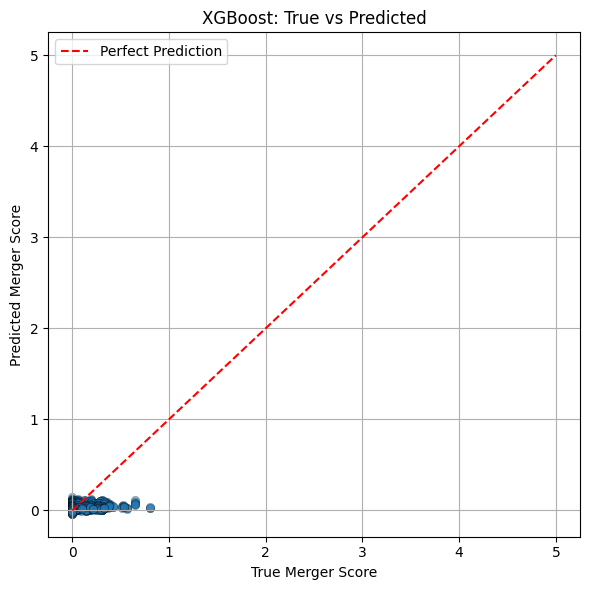

Training R²: 0.0809
Training MSE: 0.0062
label_scores_tau0.2 for halo 476245 and snap 80 vansish
label_scores_tau0.2 for halo 1263653 and snap 89 vansish
label_scores_tau0.2 for halo 3556542 and snap 87 vansish
label_scores_tau0.2 for halo 8714627 and snap 74 vansish
label_scores_tau0.2 for halo 8714627 and snap 90 vansish
label_scores_tau0.2 for halo 10017312 and snap 92 vansish
label_scores_tau0.2 for halo 10612178 and snap 78 vansish
label_scores_tau0.2 for halo 11484512 and snap 76 vansish
label_scores_tau0.2 for halo 13792287 and snap 89 vansish
label_scores_tau0.2 for halo 15031462 and snap 91 vansish
label_scores_tau0.2 for halo 15620242 and snap 96 vansish
label_scores_tau0.2 for halo 16103108 and snap 94 vansish
label_scores_tau0.2 for halo 16276166 and snap 77 vansish
label_scores_tau0.2 for halo 16892124 and snap 98 vansish
label_scores_tau0.2 for halo 18057470 and snap 76 vansish
label_scores_tau0.2 for halo 18351627 and snap 92 vansish
label_scores_tau0.2 for halo 18969218

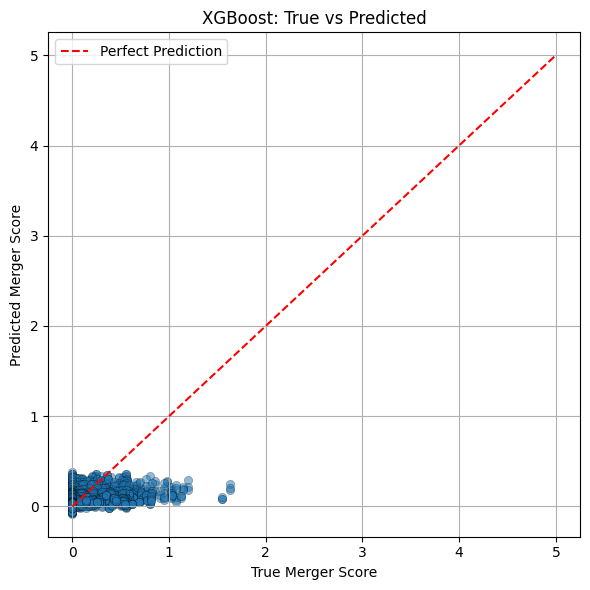

Training R²: 0.1267
Training MSE: 0.0343
label_scores_tau0.3 for halo 476245 and snap 80 vansish
label_scores_tau0.3 for halo 1263653 and snap 89 vansish
label_scores_tau0.3 for halo 3556542 and snap 87 vansish
label_scores_tau0.3 for halo 8714627 and snap 74 vansish
label_scores_tau0.3 for halo 8714627 and snap 90 vansish
label_scores_tau0.3 for halo 10017312 and snap 92 vansish
label_scores_tau0.3 for halo 10612178 and snap 78 vansish
label_scores_tau0.3 for halo 11484512 and snap 76 vansish
label_scores_tau0.3 for halo 13792287 and snap 89 vansish
label_scores_tau0.3 for halo 15031462 and snap 91 vansish
label_scores_tau0.3 for halo 15620242 and snap 96 vansish
label_scores_tau0.3 for halo 16103108 and snap 94 vansish
label_scores_tau0.3 for halo 16276166 and snap 77 vansish
label_scores_tau0.3 for halo 18057470 and snap 76 vansish
label_scores_tau0.3 for halo 18351627 and snap 92 vansish
label_scores_tau0.3 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candi

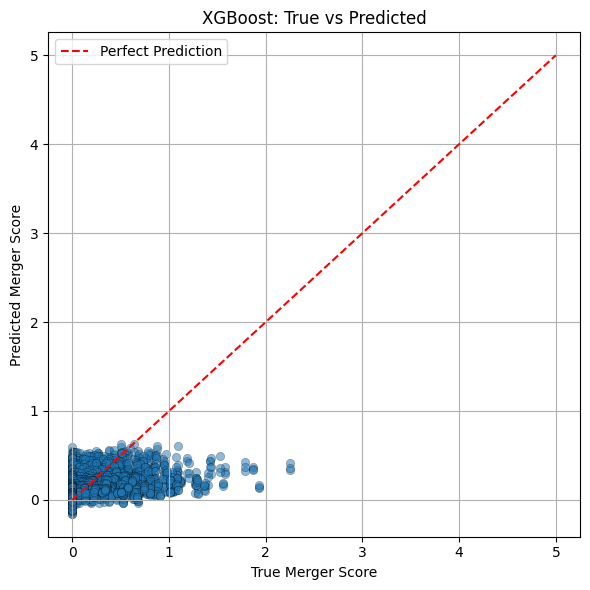

Training R²: 0.1711
Training MSE: 0.0705
label_scores_tau0.4 for halo 476245 and snap 80 vansish
label_scores_tau0.4 for halo 1263653 and snap 89 vansish
label_scores_tau0.4 for halo 3556542 and snap 87 vansish
label_scores_tau0.4 for halo 8714627 and snap 74 vansish
label_scores_tau0.4 for halo 8714627 and snap 90 vansish
label_scores_tau0.4 for halo 10017312 and snap 92 vansish
label_scores_tau0.4 for halo 10612178 and snap 78 vansish
label_scores_tau0.4 for halo 11484512 and snap 76 vansish
label_scores_tau0.4 for halo 13792287 and snap 89 vansish
label_scores_tau0.4 for halo 15031462 and snap 91 vansish
label_scores_tau0.4 for halo 15620242 and snap 96 vansish
label_scores_tau0.4 for halo 16103108 and snap 94 vansish
label_scores_tau0.4 for halo 16276166 and snap 77 vansish
label_scores_tau0.4 for halo 18057470 and snap 76 vansish
label_scores_tau0.4 for halo 18351627 and snap 92 vansish
label_scores_tau0.4 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candi

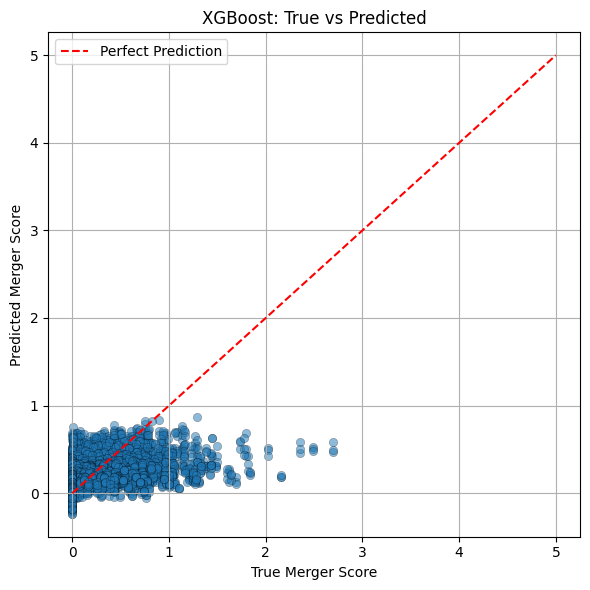

Training R²: 0.2021
Training MSE: 0.1087
label_scores_tau0.5 for halo 476245 and snap 80 vansish
label_scores_tau0.5 for halo 1263653 and snap 89 vansish
label_scores_tau0.5 for halo 3556542 and snap 87 vansish
label_scores_tau0.5 for halo 8714627 and snap 74 vansish
label_scores_tau0.5 for halo 8714627 and snap 90 vansish
label_scores_tau0.5 for halo 10017312 and snap 92 vansish
label_scores_tau0.5 for halo 10612178 and snap 78 vansish
label_scores_tau0.5 for halo 11484512 and snap 76 vansish
label_scores_tau0.5 for halo 13792287 and snap 89 vansish
label_scores_tau0.5 for halo 15031462 and snap 91 vansish
label_scores_tau0.5 for halo 15620242 and snap 96 vansish
label_scores_tau0.5 for halo 16103108 and snap 94 vansish
label_scores_tau0.5 for halo 16276166 and snap 77 vansish
label_scores_tau0.5 for halo 18057470 and snap 76 vansish
label_scores_tau0.5 for halo 18351627 and snap 92 vansish
label_scores_tau0.5 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candi

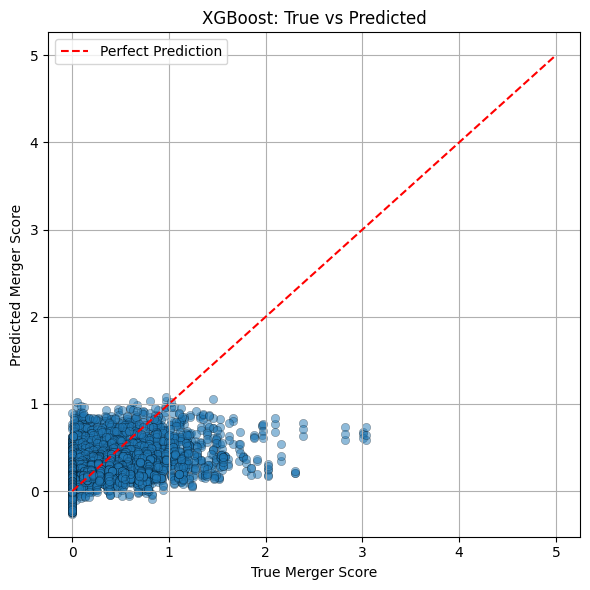

Training R²: 0.2335
Training MSE: 0.1488
label_scores_tau0.6 for halo 476245 and snap 80 vansish
label_scores_tau0.6 for halo 1263653 and snap 89 vansish
label_scores_tau0.6 for halo 3556542 and snap 87 vansish
label_scores_tau0.6 for halo 8714627 and snap 74 vansish
label_scores_tau0.6 for halo 8714627 and snap 90 vansish
label_scores_tau0.6 for halo 10017312 and snap 92 vansish
label_scores_tau0.6 for halo 10612178 and snap 78 vansish
label_scores_tau0.6 for halo 11484512 and snap 76 vansish
label_scores_tau0.6 for halo 13792287 and snap 89 vansish
label_scores_tau0.6 for halo 15031462 and snap 91 vansish
label_scores_tau0.6 for halo 16103108 and snap 94 vansish
label_scores_tau0.6 for halo 16276166 and snap 77 vansish
label_scores_tau0.6 for halo 18057470 and snap 76 vansish
label_scores_tau0.6 for halo 18351627 and snap 92 vansish
label_scores_tau0.6 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0

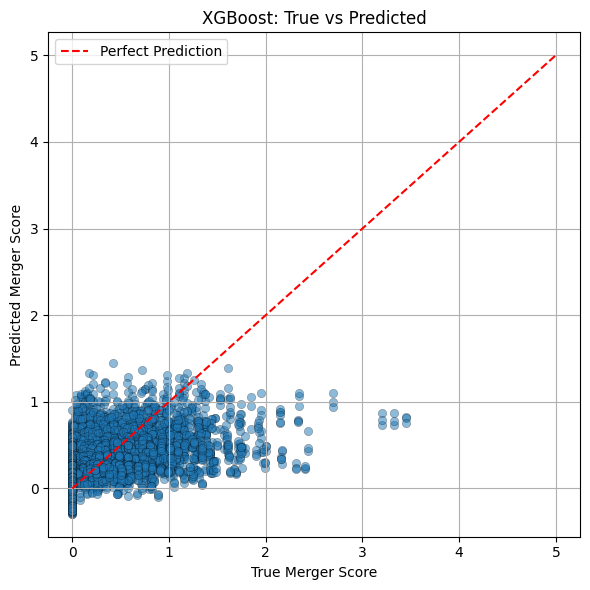

Training R²: 0.2623
Training MSE: 0.1874
label_scores_tau0.7 for halo 476245 and snap 80 vansish
label_scores_tau0.7 for halo 1263653 and snap 89 vansish
label_scores_tau0.7 for halo 3556542 and snap 87 vansish
label_scores_tau0.7 for halo 8714627 and snap 74 vansish
label_scores_tau0.7 for halo 8714627 and snap 90 vansish
label_scores_tau0.7 for halo 10017312 and snap 92 vansish
label_scores_tau0.7 for halo 10612178 and snap 78 vansish
label_scores_tau0.7 for halo 11484512 and snap 76 vansish
label_scores_tau0.7 for halo 13792287 and snap 89 vansish
label_scores_tau0.7 for halo 15031462 and snap 91 vansish
label_scores_tau0.7 for halo 16103108 and snap 94 vansish
label_scores_tau0.7 for halo 16276166 and snap 77 vansish
label_scores_tau0.7 for halo 18057470 and snap 76 vansish
label_scores_tau0.7 for halo 18351627 and snap 92 vansish
label_scores_tau0.7 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0

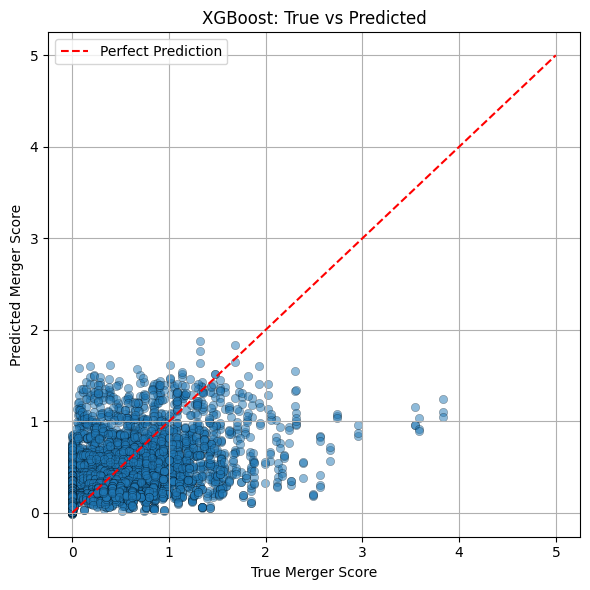

Training R²: 0.3719
Training MSE: 0.1970
label_scores_tau0.8 for halo 476245 and snap 80 vansish
label_scores_tau0.8 for halo 1263653 and snap 89 vansish
label_scores_tau0.8 for halo 3556542 and snap 87 vansish
label_scores_tau0.8 for halo 8714627 and snap 74 vansish
label_scores_tau0.8 for halo 8714627 and snap 90 vansish
label_scores_tau0.8 for halo 10017312 and snap 92 vansish
label_scores_tau0.8 for halo 10612178 and snap 78 vansish
label_scores_tau0.8 for halo 11484512 and snap 76 vansish
label_scores_tau0.8 for halo 13792287 and snap 89 vansish
label_scores_tau0.8 for halo 15031462 and snap 91 vansish
label_scores_tau0.8 for halo 16103108 and snap 94 vansish
label_scores_tau0.8 for halo 16276166 and snap 77 vansish
label_scores_tau0.8 for halo 18057470 and snap 76 vansish
label_scores_tau0.8 for halo 18351627 and snap 92 vansish
label_scores_tau0.8 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0

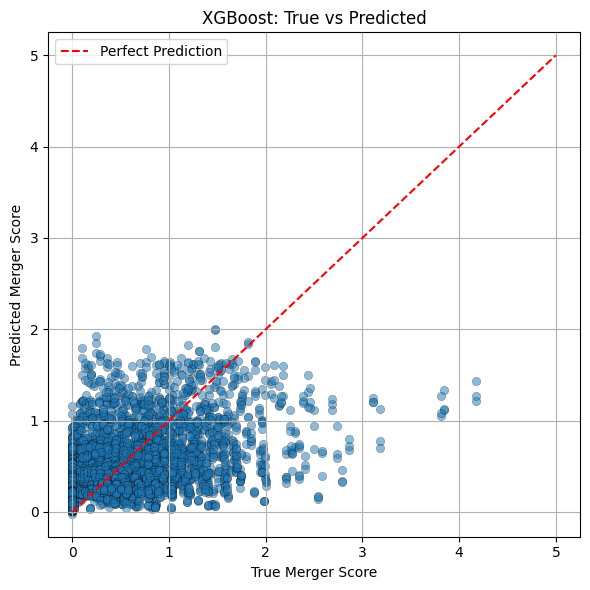

Training R²: 0.3986
Training MSE: 0.2270
label_scores_tau0.9 for halo 476245 and snap 80 vansish
label_scores_tau0.9 for halo 1263653 and snap 89 vansish
label_scores_tau0.9 for halo 3556542 and snap 87 vansish
label_scores_tau0.9 for halo 8714627 and snap 74 vansish
label_scores_tau0.9 for halo 8714627 and snap 90 vansish
label_scores_tau0.9 for halo 10017312 and snap 92 vansish
label_scores_tau0.9 for halo 10612178 and snap 78 vansish
label_scores_tau0.9 for halo 11484512 and snap 76 vansish
label_scores_tau0.9 for halo 13792287 and snap 89 vansish
label_scores_tau0.9 for halo 15031462 and snap 91 vansish
label_scores_tau0.9 for halo 16103108 and snap 94 vansish
label_scores_tau0.9 for halo 16276166 and snap 77 vansish
label_scores_tau0.9 for halo 18057470 and snap 76 vansish
label_scores_tau0.9 for halo 18351627 and snap 92 vansish
label_scores_tau0.9 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0

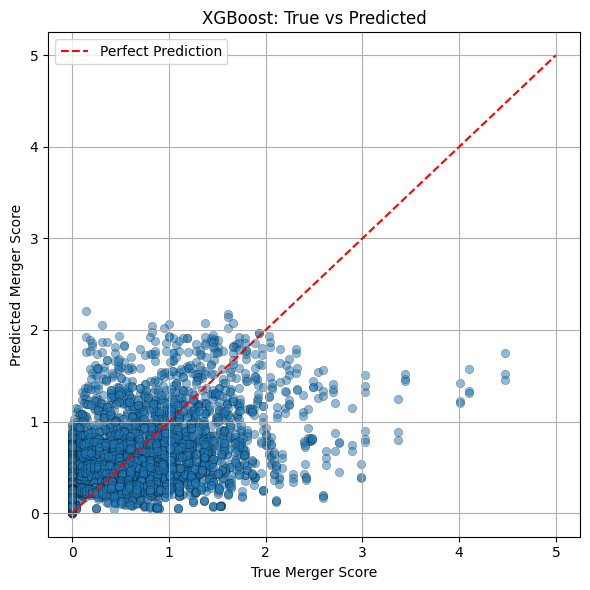

Training R²: 0.4181
Training MSE: 0.2554
label_scores_tau1.0 for halo 476245 and snap 80 vansish
label_scores_tau1.0 for halo 1263653 and snap 89 vansish
label_scores_tau1.0 for halo 3556542 and snap 87 vansish
label_scores_tau1.0 for halo 8714627 and snap 74 vansish
label_scores_tau1.0 for halo 8714627 and snap 90 vansish
label_scores_tau1.0 for halo 10017312 and snap 92 vansish
label_scores_tau1.0 for halo 10612178 and snap 78 vansish
label_scores_tau1.0 for halo 11484512 and snap 76 vansish
label_scores_tau1.0 for halo 13792287 and snap 89 vansish
label_scores_tau1.0 for halo 15031462 and snap 91 vansish
label_scores_tau1.0 for halo 16276166 and snap 77 vansish
label_scores_tau1.0 for halo 18057470 and snap 76 vansish
label_scores_tau1.0 for halo 18351627 and snap 92 vansish
label_scores_tau1.0 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
XGBoost MSE: 0.3

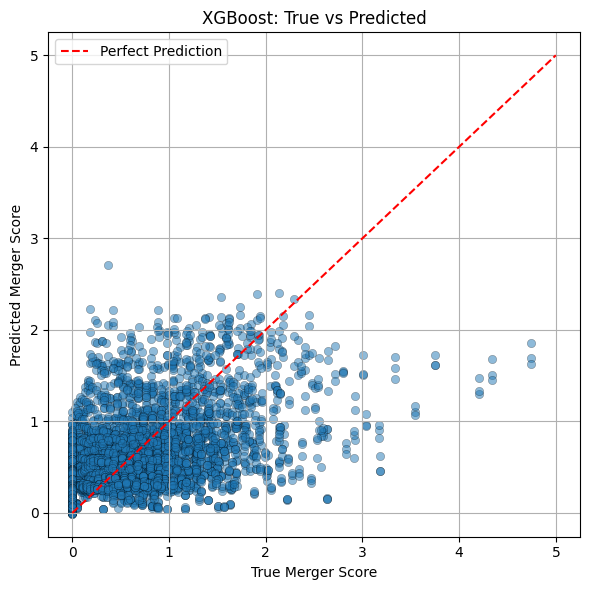

Training R²: 0.4406
Training MSE: 0.2822
label_scores_tau1.1 for halo 476245 and snap 80 vansish
label_scores_tau1.1 for halo 1263653 and snap 89 vansish
label_scores_tau1.1 for halo 3556542 and snap 87 vansish
label_scores_tau1.1 for halo 8714627 and snap 74 vansish
label_scores_tau1.1 for halo 8714627 and snap 90 vansish
label_scores_tau1.1 for halo 10017312 and snap 92 vansish
label_scores_tau1.1 for halo 10612178 and snap 78 vansish
label_scores_tau1.1 for halo 11484512 and snap 76 vansish
label_scores_tau1.1 for halo 13792287 and snap 89 vansish
label_scores_tau1.1 for halo 15031462 and snap 91 vansish
label_scores_tau1.1 for halo 16276166 and snap 77 vansish
label_scores_tau1.1 for halo 18057470 and snap 76 vansish
label_scores_tau1.1 for halo 18351627 and snap 92 vansish
label_scores_tau1.1 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
XGBoost MSE: 0.3

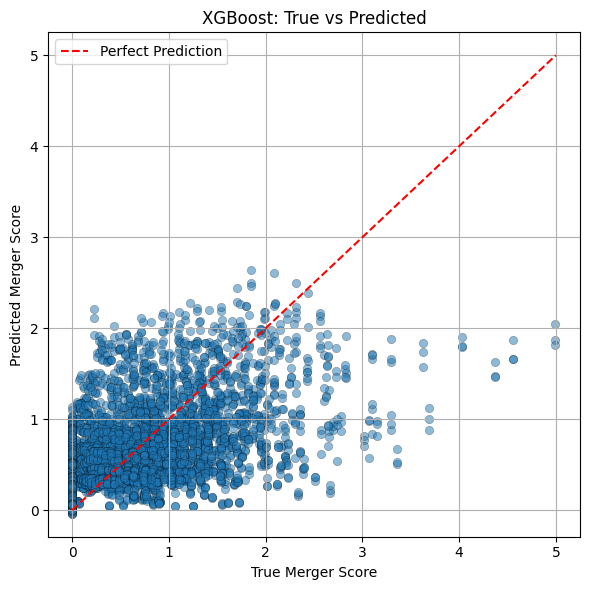

Training R²: 0.4644
Training MSE: 0.3062
label_scores_tau1.2 for halo 476245 and snap 80 vansish
label_scores_tau1.2 for halo 1263653 and snap 89 vansish
label_scores_tau1.2 for halo 3556542 and snap 87 vansish
label_scores_tau1.2 for halo 8714627 and snap 74 vansish
label_scores_tau1.2 for halo 8714627 and snap 90 vansish
label_scores_tau1.2 for halo 10017312 and snap 92 vansish
label_scores_tau1.2 for halo 10612178 and snap 78 vansish
label_scores_tau1.2 for halo 11484512 and snap 76 vansish
label_scores_tau1.2 for halo 13792287 and snap 89 vansish
label_scores_tau1.2 for halo 15031462 and snap 91 vansish
label_scores_tau1.2 for halo 16276166 and snap 77 vansish
label_scores_tau1.2 for halo 18057470 and snap 76 vansish
label_scores_tau1.2 for halo 18351627 and snap 92 vansish
label_scores_tau1.2 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
XGBoost MSE: 0.4

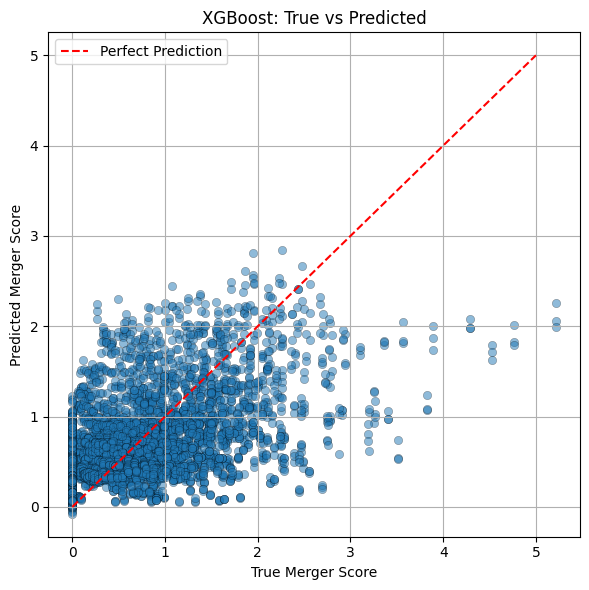

Training R²: 0.4748
Training MSE: 0.3330
label_scores_tau1.3 for halo 476245 and snap 80 vansish
label_scores_tau1.3 for halo 1263653 and snap 89 vansish
label_scores_tau1.3 for halo 3556542 and snap 87 vansish
label_scores_tau1.3 for halo 8714627 and snap 74 vansish
label_scores_tau1.3 for halo 8714627 and snap 90 vansish
label_scores_tau1.3 for halo 10612178 and snap 78 vansish
label_scores_tau1.3 for halo 11484512 and snap 76 vansish
label_scores_tau1.3 for halo 13792287 and snap 89 vansish
label_scores_tau1.3 for halo 15031462 and snap 91 vansish
label_scores_tau1.3 for halo 16276166 and snap 77 vansish
label_scores_tau1.3 for halo 18057470 and snap 76 vansish
label_scores_tau1.3 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 1000}
XGBoost MSE: 0.4281
XGBoost R²: 0.2893


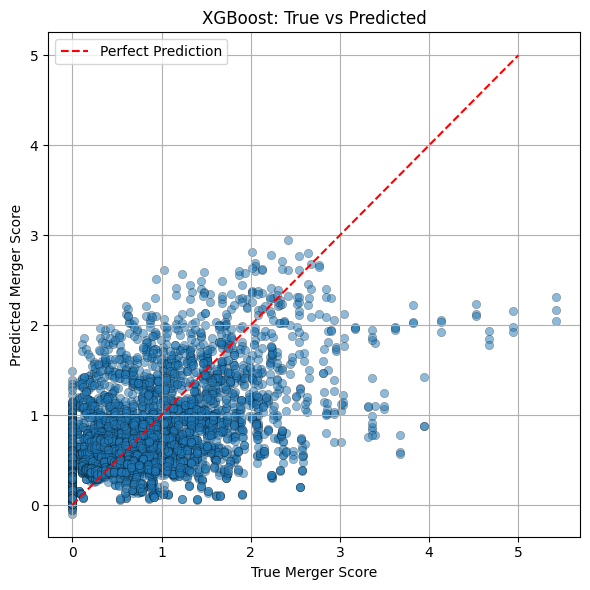

Training R²: 0.4995
Training MSE: 0.3507
label_scores_tau1.4 for halo 476245 and snap 80 vansish
label_scores_tau1.4 for halo 1263653 and snap 89 vansish
label_scores_tau1.4 for halo 3556542 and snap 87 vansish
label_scores_tau1.4 for halo 8714627 and snap 74 vansish
label_scores_tau1.4 for halo 8714627 and snap 90 vansish
label_scores_tau1.4 for halo 10612178 and snap 78 vansish
label_scores_tau1.4 for halo 11484512 and snap 76 vansish
label_scores_tau1.4 for halo 13792287 and snap 89 vansish
label_scores_tau1.4 for halo 15031462 and snap 91 vansish
label_scores_tau1.4 for halo 16276166 and snap 77 vansish
label_scores_tau1.4 for halo 18057470 and snap 76 vansish
label_scores_tau1.4 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
XGBoost MSE: 0.4588
XGBoost R²: 0.3002


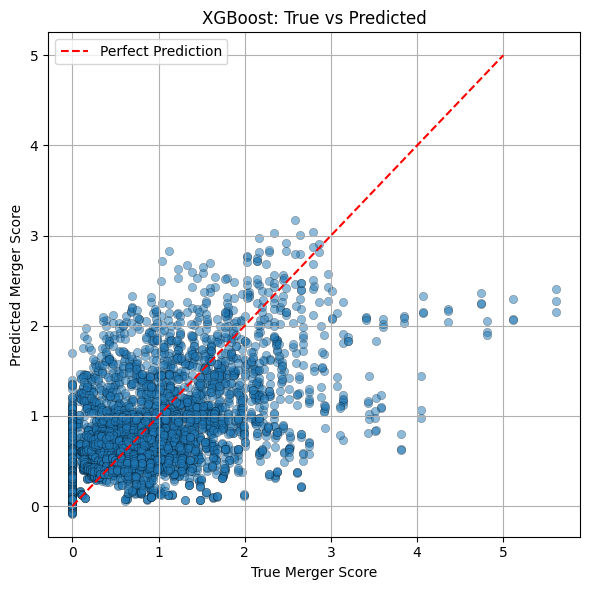

Training R²: 0.5094
Training MSE: 0.3740
label_scores_tau1.5 for halo 476245 and snap 80 vansish
label_scores_tau1.5 for halo 1263653 and snap 89 vansish
label_scores_tau1.5 for halo 3556542 and snap 87 vansish
label_scores_tau1.5 for halo 8714627 and snap 74 vansish
label_scores_tau1.5 for halo 8714627 and snap 90 vansish
label_scores_tau1.5 for halo 10612178 and snap 78 vansish
label_scores_tau1.5 for halo 11484512 and snap 76 vansish
label_scores_tau1.5 for halo 13792287 and snap 89 vansish
label_scores_tau1.5 for halo 16276166 and snap 77 vansish
label_scores_tau1.5 for halo 18057470 and snap 76 vansish
label_scores_tau1.5 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 1000}
XGBoost MSE: 0.4823
XGBoost R²: 0.3180


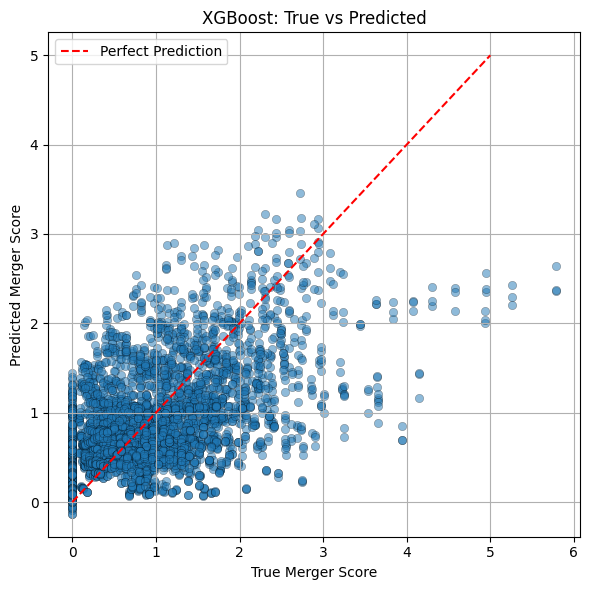

Training R²: 0.5279
Training MSE: 0.3919
label_scores_tau1.6 for halo 476245 and snap 80 vansish
label_scores_tau1.6 for halo 1263653 and snap 89 vansish
label_scores_tau1.6 for halo 3556542 and snap 87 vansish
label_scores_tau1.6 for halo 8714627 and snap 74 vansish
label_scores_tau1.6 for halo 10612178 and snap 78 vansish
label_scores_tau1.6 for halo 11484512 and snap 76 vansish
label_scores_tau1.6 for halo 13792287 and snap 89 vansish
label_scores_tau1.6 for halo 16276166 and snap 77 vansish
label_scores_tau1.6 for halo 18057470 and snap 76 vansish
label_scores_tau1.6 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 1000}
XGBoost MSE: 0.5096
XGBoost R²: 0.3299


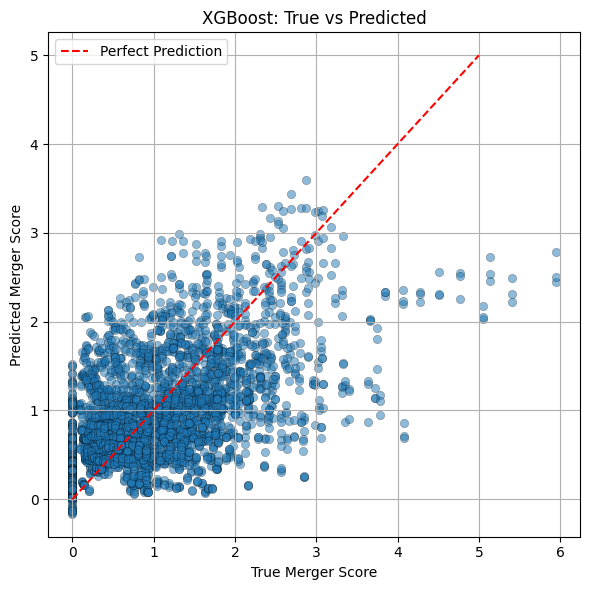

Training R²: 0.5458
Training MSE: 0.4054
label_scores_tau1.7 for halo 476245 and snap 80 vansish
label_scores_tau1.7 for halo 1263653 and snap 89 vansish
label_scores_tau1.7 for halo 3556542 and snap 87 vansish
label_scores_tau1.7 for halo 8714627 and snap 74 vansish
label_scores_tau1.7 for halo 10612178 and snap 78 vansish
label_scores_tau1.7 for halo 11484512 and snap 76 vansish
label_scores_tau1.7 for halo 13792287 and snap 89 vansish
label_scores_tau1.7 for halo 16276166 and snap 77 vansish
label_scores_tau1.7 for halo 18057470 and snap 76 vansish
label_scores_tau1.7 for halo 18969218 and snap 89 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
XGBoost MSE: 0.5370
XGBoost R²: 0.3393


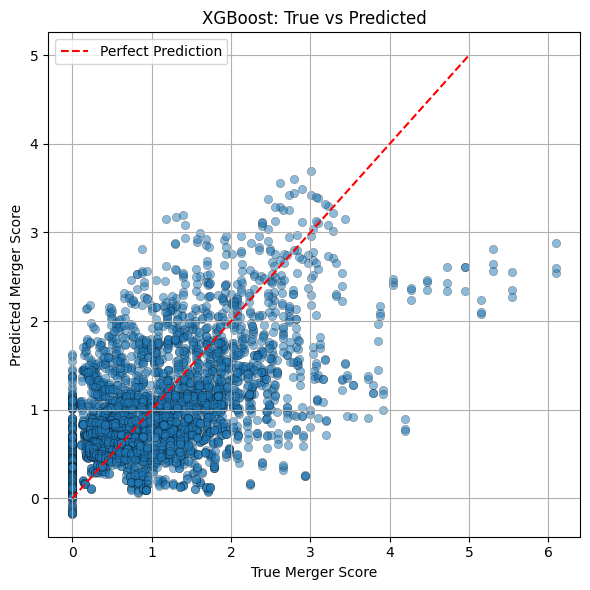

Training R²: 0.5518
Training MSE: 0.4271
label_scores_tau1.8 for halo 476245 and snap 80 vansish
label_scores_tau1.8 for halo 3556542 and snap 87 vansish
label_scores_tau1.8 for halo 8714627 and snap 74 vansish
label_scores_tau1.8 for halo 10612178 and snap 78 vansish
label_scores_tau1.8 for halo 11484512 and snap 76 vansish
label_scores_tau1.8 for halo 16276166 and snap 77 vansish
label_scores_tau1.8 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
XGBoost MSE: 0.5745
XGBoost R²: 0.3420


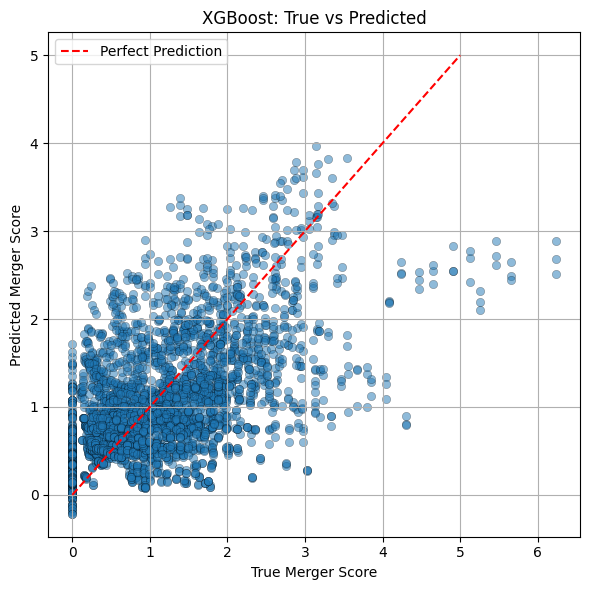

Training R²: 0.5724
Training MSE: 0.4361
label_scores_tau1.9 for halo 476245 and snap 80 vansish
label_scores_tau1.9 for halo 3556542 and snap 87 vansish
label_scores_tau1.9 for halo 8714627 and snap 74 vansish
label_scores_tau1.9 for halo 10612178 and snap 78 vansish
label_scores_tau1.9 for halo 11484512 and snap 76 vansish
label_scores_tau1.9 for halo 16276166 and snap 77 vansish
label_scores_tau1.9 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
XGBoost MSE: 0.5967
XGBoost R²: 0.3544


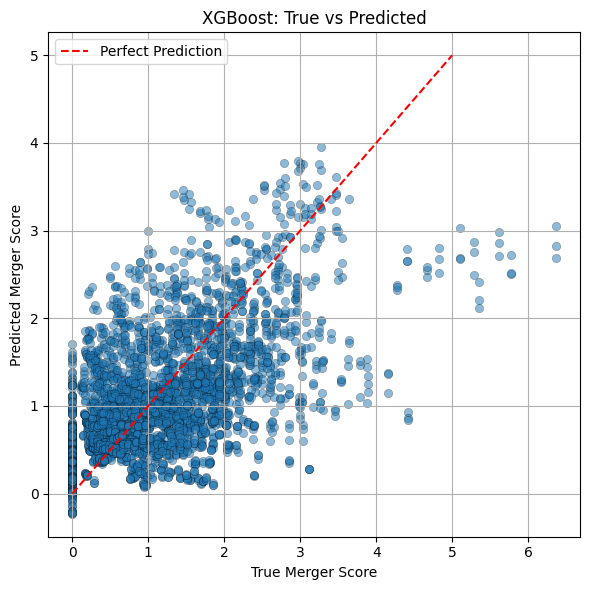

Training R²: 0.5741
Training MSE: 0.4595
label_scores_tau2.0 for halo 476245 and snap 80 vansish
label_scores_tau2.0 for halo 3556542 and snap 87 vansish
label_scores_tau2.0 for halo 8714627 and snap 74 vansish
label_scores_tau2.0 for halo 10612178 and snap 78 vansish
label_scores_tau2.0 for halo 11484512 and snap 76 vansish
label_scores_tau2.0 for halo 16276166 and snap 77 vansish
label_scores_tau2.0 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
XGBoost MSE: 0.6498
XGBoost R²: 0.3409


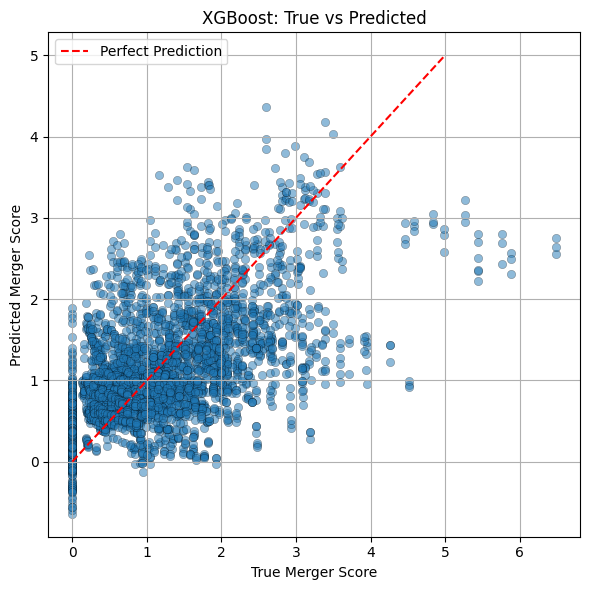

Training R²: 0.5556
Training MSE: 0.5085
label_scores_tau2.1 for halo 476245 and snap 80 vansish
label_scores_tau2.1 for halo 8714627 and snap 74 vansish
label_scores_tau2.1 for halo 10612178 and snap 78 vansish
label_scores_tau2.1 for halo 11484512 and snap 76 vansish
label_scores_tau2.1 for halo 16276166 and snap 77 vansish
label_scores_tau2.1 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
XGBoost MSE: 0.6758
XGBoost R²: 0.3527


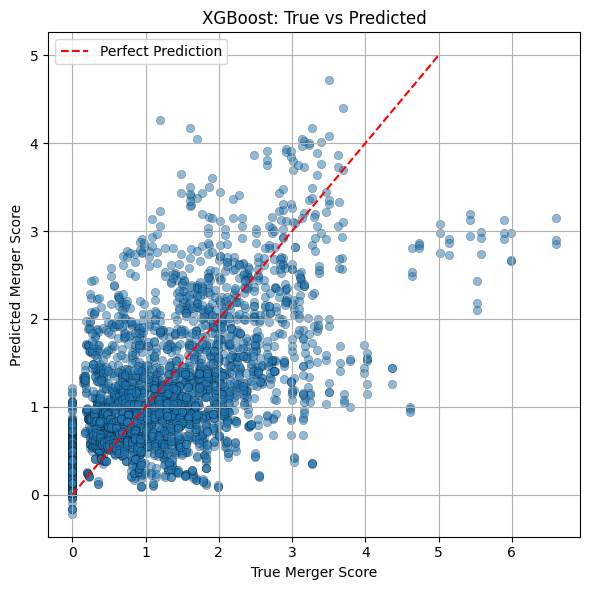

Training R²: 0.6082
Training MSE: 0.4739
label_scores_tau2.2 for halo 476245 and snap 80 vansish
label_scores_tau2.2 for halo 8714627 and snap 74 vansish
label_scores_tau2.2 for halo 10612178 and snap 78 vansish
label_scores_tau2.2 for halo 11484512 and snap 76 vansish
label_scores_tau2.2 for halo 16276166 and snap 77 vansish
label_scores_tau2.2 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
XGBoost MSE: 0.6988
XGBoost R²: 0.3608


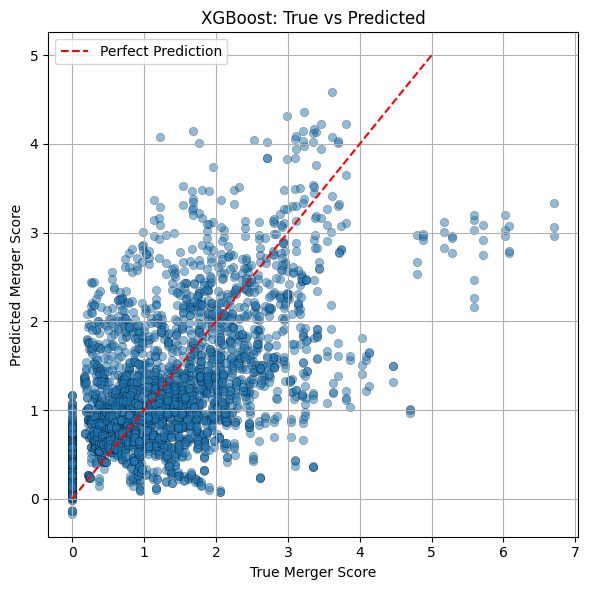

Training R²: 0.6092
Training MSE: 0.4950
label_scores_tau2.3 for halo 476245 and snap 80 vansish
label_scores_tau2.3 for halo 8714627 and snap 74 vansish
label_scores_tau2.3 for halo 10612178 and snap 78 vansish
label_scores_tau2.3 for halo 11484512 and snap 76 vansish
label_scores_tau2.3 for halo 16276166 and snap 77 vansish
label_scores_tau2.3 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
XGBoost MSE: 0.7234
XGBoost R²: 0.3706


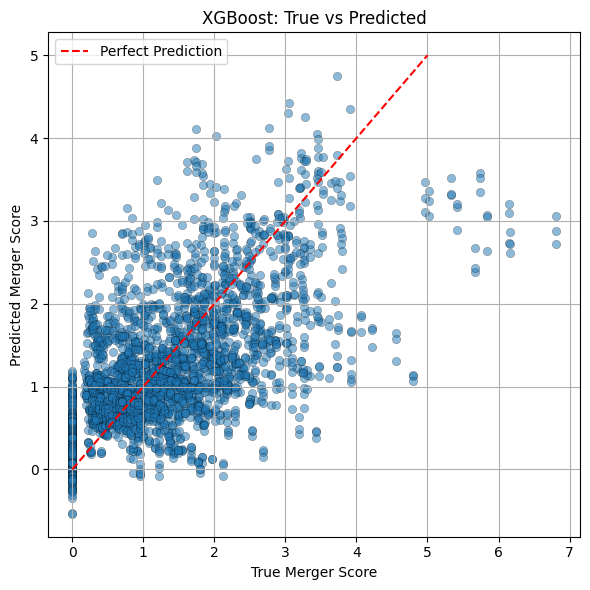

Training R²: 0.5816
Training MSE: 0.5555
label_scores_tau2.4 for halo 476245 and snap 80 vansish
label_scores_tau2.4 for halo 8714627 and snap 74 vansish
label_scores_tau2.4 for halo 10612178 and snap 78 vansish
label_scores_tau2.4 for halo 11484512 and snap 76 vansish
label_scores_tau2.4 for halo 16276166 and snap 77 vansish
label_scores_tau2.4 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 300}
XGBoost MSE: 0.7707
XGBoost R²: 0.3605


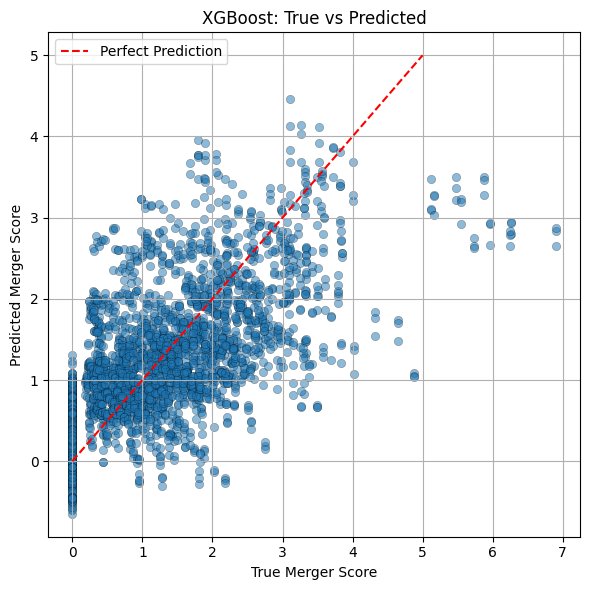

Training R²: 0.5370
Training MSE: 0.6432
label_scores_tau2.5 for halo 476245 and snap 80 vansish
label_scores_tau2.5 for halo 8714627 and snap 74 vansish
label_scores_tau2.5 for halo 10612178 and snap 78 vansish
label_scores_tau2.5 for halo 11484512 and snap 76 vansish
label_scores_tau2.5 for halo 16276166 and snap 77 vansish
label_scores_tau2.5 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}
XGBoost MSE: 0.7909
XGBoost R²: 0.3687


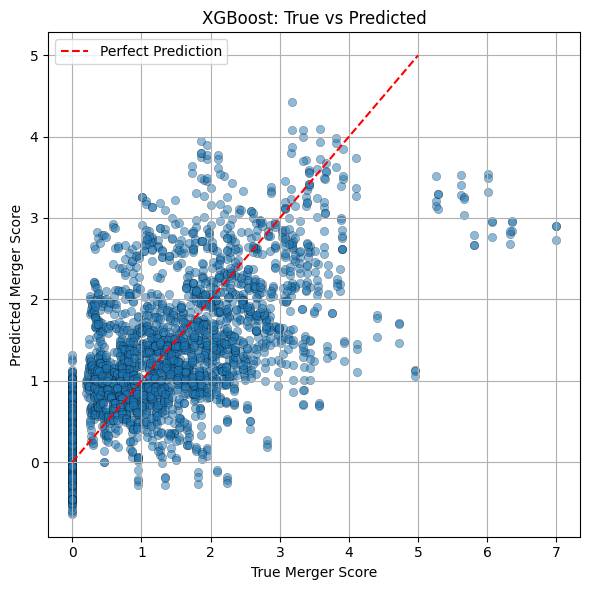

Training R²: 0.5340
Training MSE: 0.6728
label_scores_tau2.6 for halo 476245 and snap 80 vansish
label_scores_tau2.6 for halo 8714627 and snap 74 vansish
label_scores_tau2.6 for halo 10612178 and snap 78 vansish
label_scores_tau2.6 for halo 11484512 and snap 76 vansish
label_scores_tau2.6 for halo 16276166 and snap 77 vansish
label_scores_tau2.6 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 300}
XGBoost MSE: 0.8442
XGBoost R²: 0.3592


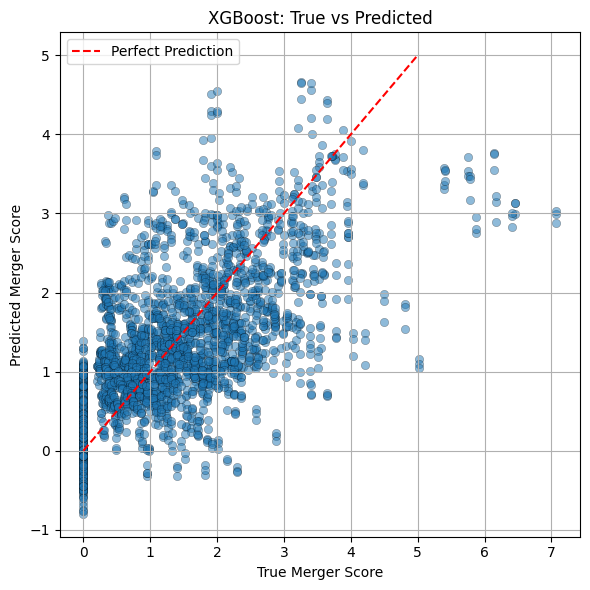

Training R²: 0.5505
Training MSE: 0.6759
label_scores_tau2.7 for halo 476245 and snap 80 vansish
label_scores_tau2.7 for halo 8714627 and snap 74 vansish
label_scores_tau2.7 for halo 10612178 and snap 78 vansish
label_scores_tau2.7 for halo 11484512 and snap 76 vansish
label_scores_tau2.7 for halo 16276166 and snap 77 vansish
label_scores_tau2.7 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 300}
XGBoost MSE: 0.8691
XGBoost R²: 0.3628


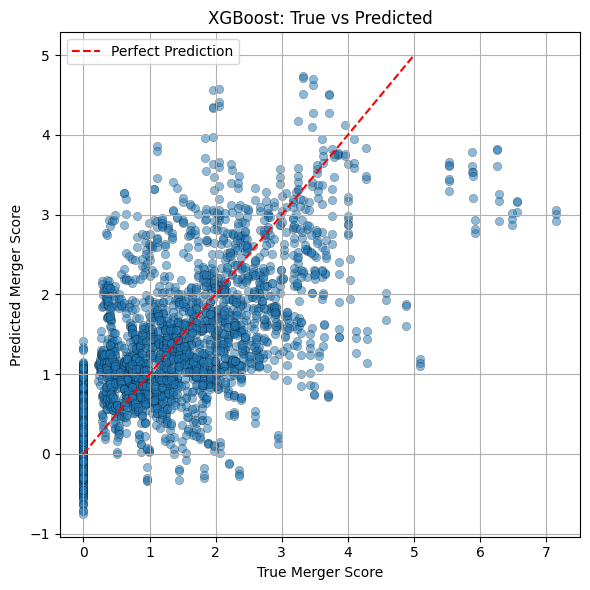

Training R²: 0.5523
Training MSE: 0.6968
label_scores_tau2.8 for halo 476245 and snap 80 vansish
label_scores_tau2.8 for halo 8714627 and snap 74 vansish
label_scores_tau2.8 for halo 10612178 and snap 78 vansish
label_scores_tau2.8 for halo 11484512 and snap 76 vansish
label_scores_tau2.8 for halo 16276166 and snap 77 vansish
label_scores_tau2.8 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 1000}
XGBoost MSE: 0.9000
XGBoost R²: 0.3702


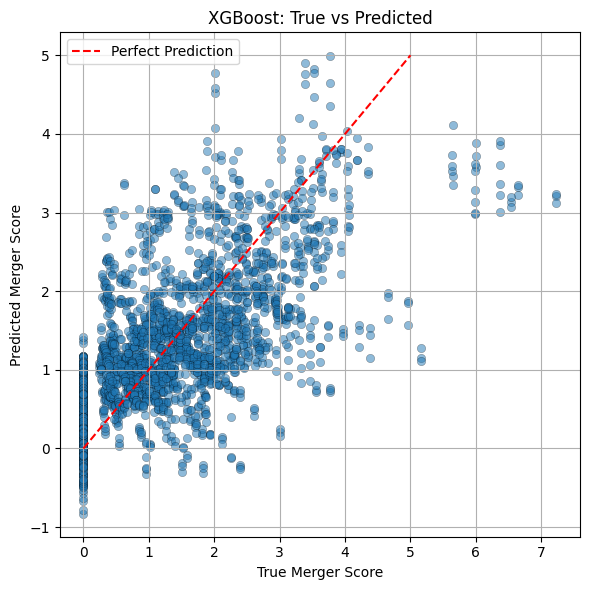

Training R²: 0.5531
Training MSE: 0.7249
label_scores_tau2.9 for halo 476245 and snap 80 vansish
label_scores_tau2.9 for halo 8714627 and snap 74 vansish
label_scores_tau2.9 for halo 10612178 and snap 78 vansish
label_scores_tau2.9 for halo 11484512 and snap 76 vansish
label_scores_tau2.9 for halo 16276166 and snap 77 vansish
label_scores_tau2.9 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 300}
XGBoost MSE: 0.9249
XGBoost R²: 0.3882


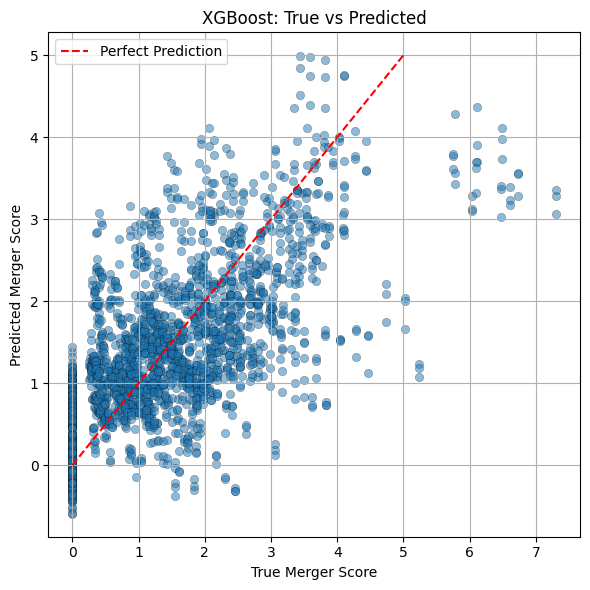

Training R²: 0.5665
Training MSE: 0.7306
label_scores_tau3.0 for halo 476245 and snap 80 vansish
label_scores_tau3.0 for halo 8714627 and snap 74 vansish
label_scores_tau3.0 for halo 10612178 and snap 78 vansish
label_scores_tau3.0 for halo 11484512 and snap 76 vansish
label_scores_tau3.0 for halo 16276166 and snap 77 vansish
label_scores_tau3.0 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 300}
XGBoost MSE: 0.9512
XGBoost R²: 0.3891


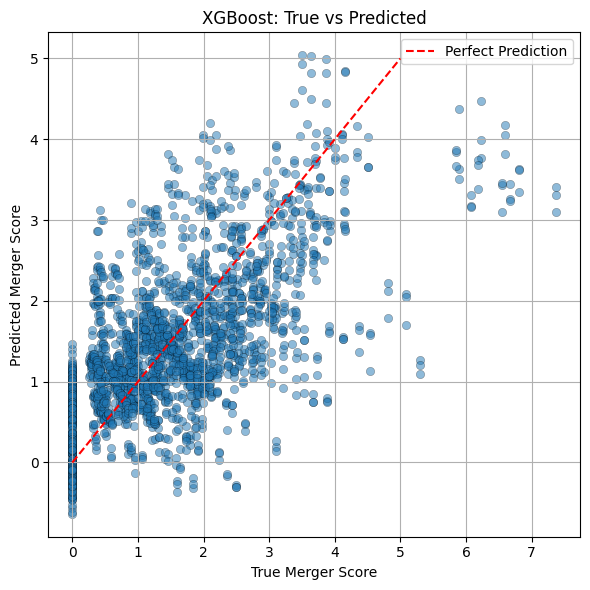

Training R²: 0.5676
Training MSE: 0.7508
label_scores_tau3.1 for halo 476245 and snap 80 vansish
label_scores_tau3.1 for halo 8714627 and snap 74 vansish
label_scores_tau3.1 for halo 10612178 and snap 78 vansish
label_scores_tau3.1 for halo 11484512 and snap 76 vansish
label_scores_tau3.1 for halo 16276166 and snap 77 vansish
label_scores_tau3.1 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000}
XGBoost MSE: 0.9870
XGBoost R²: 0.3916


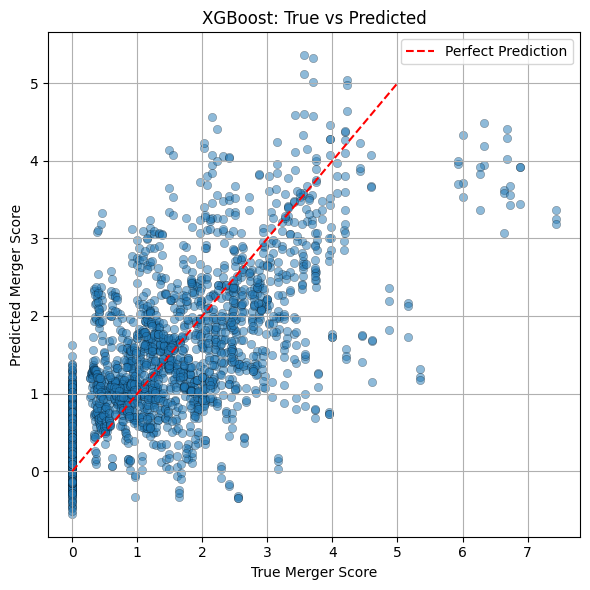

Training R²: 0.5897
Training MSE: 0.7435
label_scores_tau3.2 for halo 476245 and snap 80 vansish
label_scores_tau3.2 for halo 8714627 and snap 74 vansish
label_scores_tau3.2 for halo 10612178 and snap 78 vansish
label_scores_tau3.2 for halo 11484512 and snap 76 vansish
label_scores_tau3.2 for halo 16276166 and snap 77 vansish
label_scores_tau3.2 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000}
XGBoost MSE: 1.0121
XGBoost R²: 0.3927


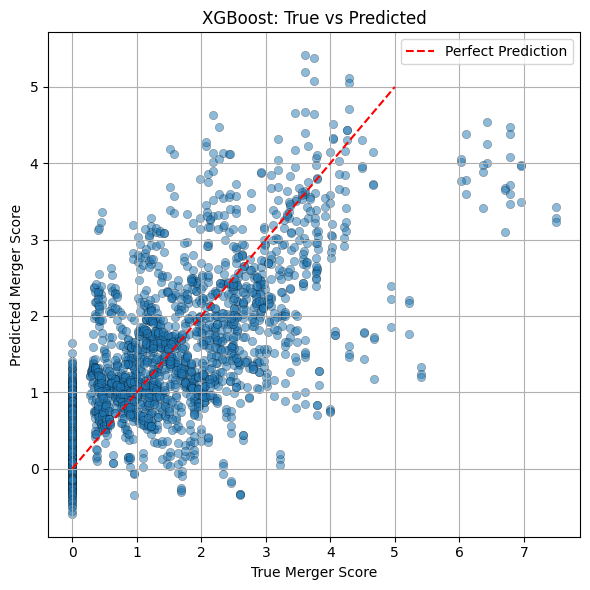

Training R²: 0.5908
Training MSE: 0.7617
label_scores_tau3.3 for halo 8714627 and snap 74 vansish
label_scores_tau3.3 for halo 10612178 and snap 78 vansish
label_scores_tau3.3 for halo 11484512 and snap 76 vansish
label_scores_tau3.3 for halo 16276166 and snap 77 vansish
label_scores_tau3.3 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000}
XGBoost MSE: 1.0306
XGBoost R²: 0.4070


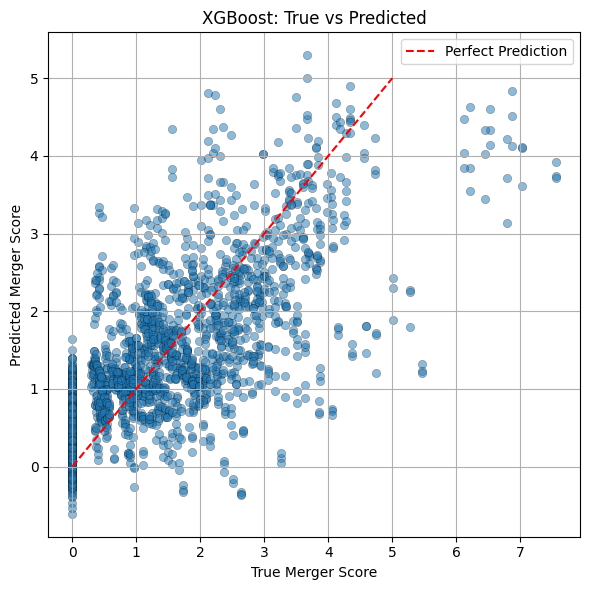

Training R²: 0.5973
Training MSE: 0.7809
label_scores_tau3.4 for halo 8714627 and snap 74 vansish
label_scores_tau3.4 for halo 10612178 and snap 78 vansish
label_scores_tau3.4 for halo 11484512 and snap 76 vansish
label_scores_tau3.4 for halo 16276166 and snap 77 vansish
label_scores_tau3.4 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
XGBoost MSE: 1.0881
XGBoost R²: 0.3961


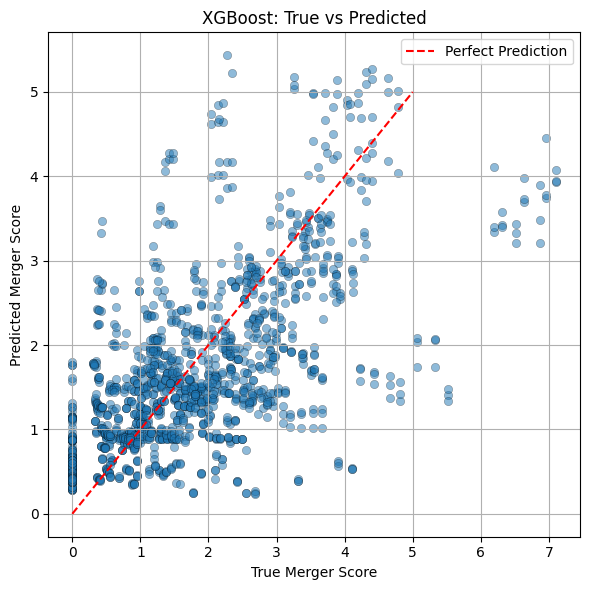

Training R²: 0.6501
Training MSE: 0.7064
label_scores_tau3.5 for halo 8714627 and snap 74 vansish
label_scores_tau3.5 for halo 10612178 and snap 78 vansish
label_scores_tau3.5 for halo 11484512 and snap 76 vansish
label_scores_tau3.5 for halo 16276166 and snap 77 vansish
label_scores_tau3.5 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
XGBoost MSE: 1.1354
XGBoost R²: 0.3846


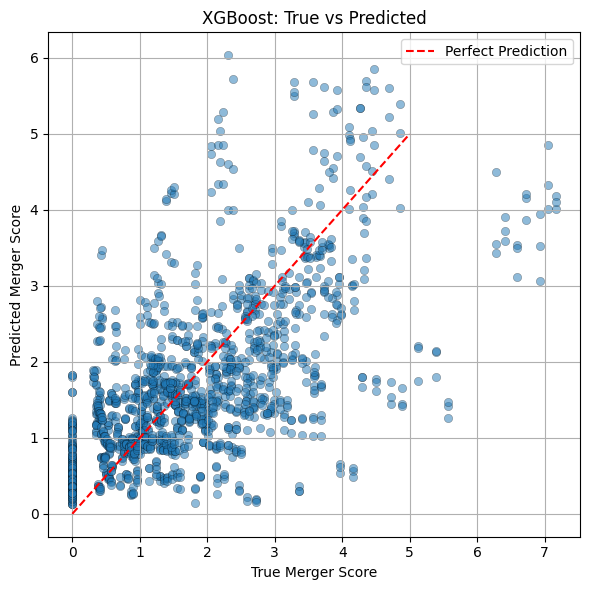

Training R²: 0.6932
Training MSE: 0.6340
label_scores_tau3.6 for halo 8714627 and snap 74 vansish
label_scores_tau3.6 for halo 11484512 and snap 76 vansish
label_scores_tau3.6 for halo 16276166 and snap 77 vansish
label_scores_tau3.6 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
XGBoost MSE: 1.1032
XGBoost R²: 0.4157


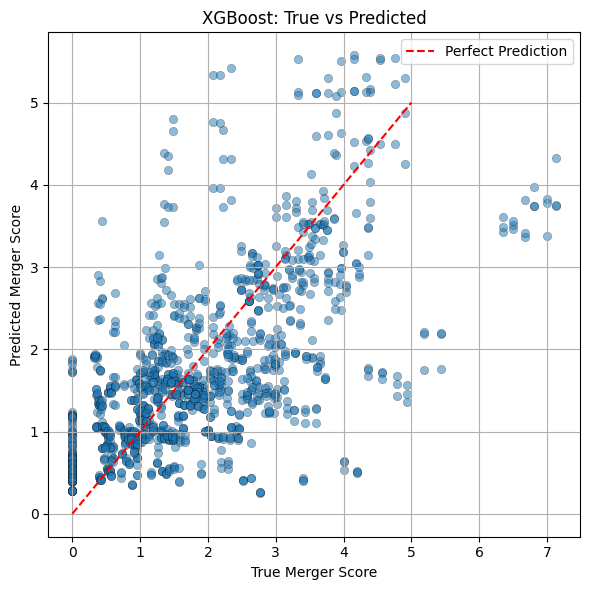

Training R²: 0.6601
Training MSE: 0.7307
label_scores_tau3.7 for halo 8714627 and snap 74 vansish
label_scores_tau3.7 for halo 11484512 and snap 76 vansish
label_scores_tau3.7 for halo 16276166 and snap 77 vansish
label_scores_tau3.7 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
XGBoost MSE: 1.1228
XGBoost R²: 0.4183


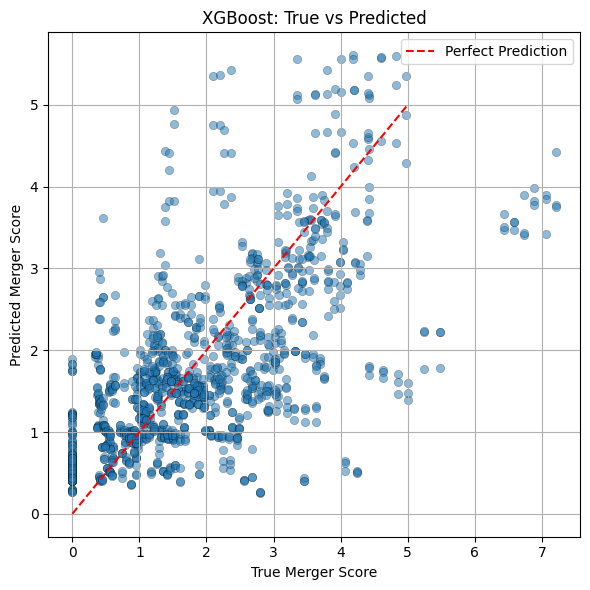

Training R²: 0.6615
Training MSE: 0.7436
label_scores_tau3.8 for halo 8714627 and snap 74 vansish
label_scores_tau3.8 for halo 11484512 and snap 76 vansish
label_scores_tau3.8 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
XGBoost MSE: 1.0572
XGBoost R²: 0.4637


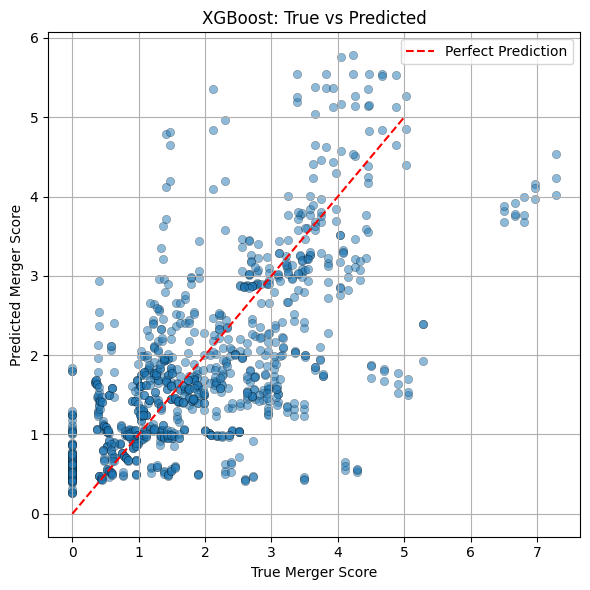

Training R²: 0.6709
Training MSE: 0.7558
label_scores_tau3.9 for halo 8714627 and snap 74 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
XGBoost MSE: 1.0035
XGBoost R²: 0.5093


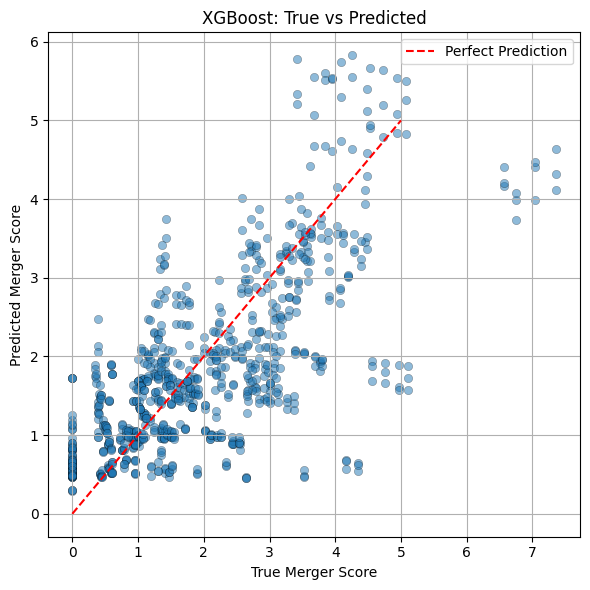

Training R²: 0.6908
Training MSE: 0.7450
label_scores_tau4.0 for halo 8714627 and snap 74 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
XGBoost MSE: 1.0228
XGBoost R²: 0.5096


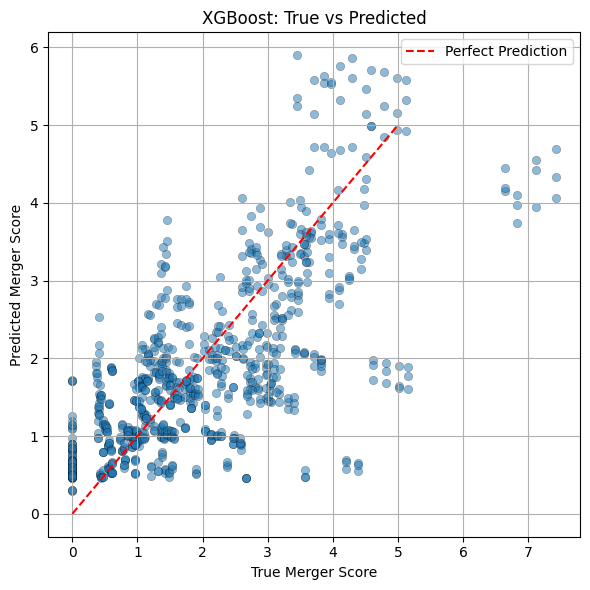

Training R²: 0.6905
Training MSE: 0.7601


In [9]:
taus = np.linspace(0.1,4.0,40)

mse_tests = np.zeros(len(taus))
R2_tests = np.zeros(len(taus))
mse_trains = np.zeros(len(taus))
R2_trains = np.zeros(len(taus))
samples = np.zeros(len(taus))

for i, tau in enumerate(taus):
    tau = round(tau, 1)
    random_state = 2025
    mse, r2, mse_train, r2_train, n_samples, _, _, _ = XGboost_singletau_premerger_allmerger(tau, state = 'post_merger', random_state = random_state)
    mse_tests[i] = mse
    R2_tests[i] = r2
    mse_trains[i] = mse_train
    R2_trains[i] = r2_train
    samples[i] = n_samples

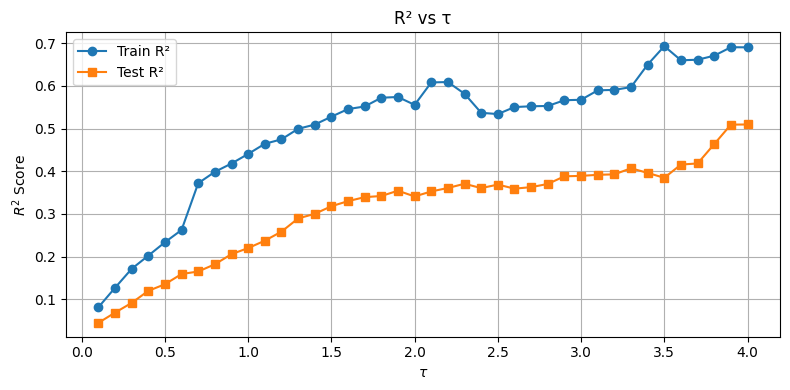

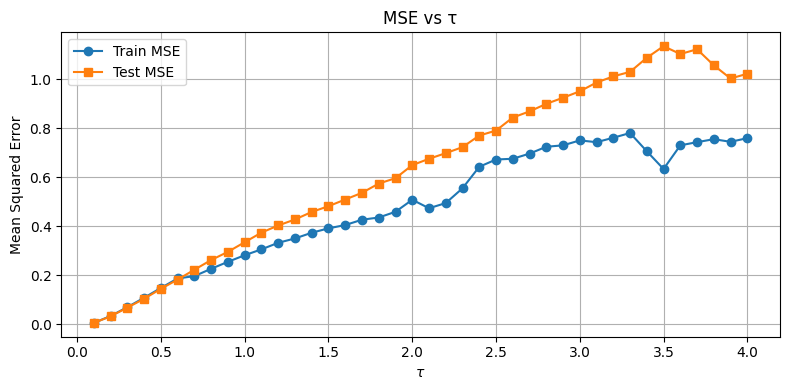

In [10]:
import matplotlib.pyplot as plt

# R2
plt.figure(figsize=(8, 4))
plt.plot(taus, R2_trains, label='Train R²', marker='o')
plt.plot(taus, R2_tests, label='Test R²', marker='s')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$R^2$ Score')
plt.title('R² vs τ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MSE
plt.figure(figsize=(8, 4))
plt.plot(taus, mse_trains, label='Train MSE', marker='o')
plt.plot(taus, mse_tests, label='Test MSE', marker='s')
plt.xlabel(r'$\tau$')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs τ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

# convert to data frame
df = pd.DataFrame({
    'tau': taus,
    'mse_test': mse_tests,
    'mse_train': mse_trains,
    'R2_test': R2_tests,
    'R2_train': R2_trains,
    'n_samples': samples
})

# asve to .csv
df.to_csv('/home/chuiyang/merger_trace/notebooks/plot/plot_data/phase-space_new/tau_scan_fullproj_baseline_post.csv', index=False)
